In [1]:
import yaml
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from proteins.config import flatten_dict

ix = pd.IndexSlice
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

In [2]:
from collections import defaultdict

df = defaultdict(list)
skip = []

for p in Path('.').glob('runs/*/*.yaml'):
    with open(p) as ex:
        ex = yaml.safe_load(ex)
    if ex['history'][-1]['status'] != 'COMPLETED':
        skip.append(p)
    else:
        df['misc', 'name', '', ''].append('_'.join(ex['fullname'].split('_')[-2:]))
        df['misc', 'time', '', ''].append((ex['history'][-1]['datetime_completed'] - ex['history'][-1]['datetime_started']).total_seconds() / 60)
        df['misc', 'gpu', '', ''].append(int(ex['history'][-1]['cuda']['devices']['cuda:0']['memory_used_max'].rstrip(' MiB')))
        df['hp', 'epochs', '', ''].append(ex['completed_epochs'])
        
        for k, v in flatten_dict(ex['data']):
            df[('hp', 'data', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['model']):
            df[('hp', 'model', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['optimizer']):
            df[('hp', 'optimizer', *k, '')].append(v)
        
        for k, v in flatten_dict(ex['loss']):
            df[('hp', 'loss', *k)].append(v)
        
        for k, v in flatten_dict(ex['metric']):
            df[('metric', *k, '')].append(v)
            
for p in Path('.').glob('../GridSearch_2019-08-18/runs/*/*.yaml'):
    with open(p) as ex:
        ex = yaml.safe_load(ex)
    if ex['history'][-1]['status'] != 'COMPLETED':
        skip.append(p)
    else:
        df['misc', 'name', '', ''].append('_'.join(ex['fullname'].split('_')[-2:]))
        df['misc', 'time', '', ''].append((ex['history'][-1]['datetime_completed'] - ex['history'][-1]['datetime_started']).total_seconds() / 60)
        df['misc', 'gpu', '', ''].append(int(ex['history'][-1]['cuda']['devices']['cuda:0']['memory_used_max'].rstrip(' MiB')))
        df['hp', 'epochs', '', ''].append(ex['completed_epochs'])
        
        for k, v in flatten_dict(ex['data']):
            df[('hp', 'data', *k, '')].append(v)
        df[('hp', 'data', 'separation', '')].append(False)
        df[('hp', 'data', 'sigma', '')].append(df[('hp', 'data', 'cutoff', '')][-1])
            
        for k, v in flatten_dict(ex['model']):
            df[('hp', 'model', *k, '')].append(v)
            
        for k, v in flatten_dict(ex['optimizer']):
            df[('hp', 'optimizer', *k, '')].append(v)
        
        for k, v in flatten_dict(ex['loss']):
            df[('hp', 'loss', *k)].append(v)
        
        for k, v in flatten_dict(ex['metric']):
            df[('metric', *k, '')].append(v)
        
df = pd.DataFrame(df).sort_index(axis='columns', inplace=False)
        
print(f'Skipped {len(skip)}')
print(f'Good {len(df)}')
df.iloc[0].to_frame('Example')

Skipped 0
Good 1011


Example
hp     data         cutoff                           8                          
                    encoding_base                    0                          
                    encoding_size                    0                          
                    separation                       True                       
                    sigma                            8                          
       epochs                                        40                         
       loss         global_gdtts           balanced  False                      
                                           name      mse                        
                                           weight    1                          
                    global_lddt            balanced  False                      
                                           name      mse                        
                                           weight    1                          
                    local_lddt             balanced  False                      
                                           name      mse                        
                                           weight    5                          
       model        batch_norm                       False                      
                    dropout                          0.1                        
                    fn                               proteins.networks.ProteinGN
                    layers                           8                          
                    mp_in_edges                      128                        
                    mp_in_globals                    256                        
                    mp_in_nodes                      512                        
                    mp_out_edges                     12                         
                    mp_out_globals                   32                         
                    mp_out_nodes                     32                         
       optimizer    fn                               torch.optim.Adam           
                    lr                               0.01                       
                    weight_decay                     1e-05                      
metric global_gdtts correlation                      3.02551e-05                
                    correlation_per_target           NaN                        
                    first_rank_loss                  0.248905                   
                    r2                              -0.0506578                  
                    rmse                             0.299856                   
       global_lddt  correlation                      1.89881e-10                
                    correlation_per_target           NaN                        
                    first_rank_loss                  0.121553                   
                    r2                              -0.0187374                  
                    rmse                             0.196085                   
       local_lddt   correlation                      0.000213313                
                    correlation_per_model            NaN                        
                    r2                              -0.00995091                 
                    rmse                             0.231505                   
misc   gpu                                           3458                       
       name                                          gifted_lewin               
       time                                          82.6706

In [3]:
fixed_hps = df.hp.nunique() == 1
display(df.hp.loc[[0], fixed_hps.values].rename(index={0:'Fixed parameters'}))

# Always keep these because we plot them later
keep = {'cutoff', 'dropout', 'layers'}
df.drop(columns=(('hp', *c) for c in fixed_hps[fixed_hps.values].index.remove_unused_levels() if c[1] not in keep), inplace=True)
df.columns = df.columns.remove_unused_levels()
df.sort_index(axis='columns', inplace=True)

loss                                    model  \
                 global_gdtts global_lddt        local_lddt batch_norm   
                         name        name weight       name              
Fixed parameters  mse          mse         1      mse        False       

                                                      optimizer  
                                           fn                fn  
                                                                 
Fixed parameters  proteins.networks.ProteinGN  torch.optim.Adam

In [4]:
display(df[df.metric.isna().any(axis=1)]
        .style
        .set_caption('<h3 align="left"> Something went wrong here </h3>')
        .applymap(lambda v: 'color: red' if pd.isna(v) else '', subset=['metric'])
        .hide_index()
)
df.dropna(subset=[c for c in df.columns if c[0] == 'metric'], how='any', axis='index', inplace=True)

## What's the best we can do?

In [5]:
idx_best = pd.concat((
    df[[c for c in df.columns if c[0] == 'metric' and c[2].startswith('correlation')]].idxmax(), 
    df[[c for c in df.columns if c[0] == 'metric' and c[2].startswith('first')]].idxmin()
)).sort_index(ascending=False).droplevel(0)

best = df.loc[idx_best, :]
best.index = idx_best.index
best = best.transpose()
s = best.style
for r in s.index:
    if r[0] == 'metric':
        if 'rank' in r[2] or 'rmse' in r[2]:
            s.apply(lambda x: ['color: orange; font-weight: bold' if v == x.min() else '' for v in x], subset=ix[r], axis=1)
        else:
            s.apply(lambda x: ['color: green; font-weight: bold' if v == x.max() else '' for v in x], subset=ix[r], axis=1)
s

In [6]:
def highlight_max(data):
    attr = 'color: green; font-weight: bold'
    m = data.values.max()
    if data.ndim == 1:  # Series
        return pd.Series(np.where(data == m, attr, ''), index=data.index)
    else:  # DataFrame
        return pd.DataFrame(np.where(data == m, attr, ''), index=data.index, columns=data.columns)

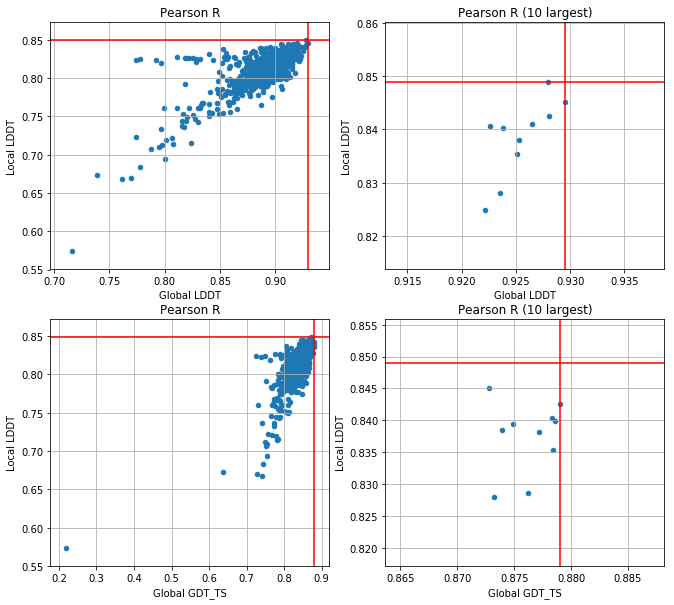

In [7]:
fig, axes = plt.subplots(2,2, figsize=(11, 10))

ax = axes.flat[0]
df.plot.scatter(ix['metric', 'global_lddt', 'correlation'], ix['metric', 'local_lddt', 'correlation'], ax=ax)
ax.set_title('Pearson R')
ax.set_xlabel('Global LDDT')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'correlation'].max(), c='r')
ax.axvline(df['metric', 'global_lddt', 'correlation'].max(), c='r')
ax.grid()

ax = axes.flat[1]
df.nlargest(10, [ix['metric', 'global_lddt', 'correlation'], ix['metric', 'local_lddt', 'correlation']]).plot.scatter(ix['metric', 'global_lddt', 'correlation'], ix['metric', 'local_lddt', 'correlation'], ax=ax)
ax.set_title('Pearson R (10 largest)')
ax.set_xlabel('Global LDDT')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'correlation'].max(), c='r')
ax.axvline(df['metric', 'global_lddt', 'correlation'].max(), c='r')
ax.grid()

ax = axes.flat[2]
df.plot.scatter(ix['metric', 'global_gdtts', 'correlation'], ix['metric', 'local_lddt', 'correlation'], ax=ax)
ax.set_title('Pearson R')
ax.set_xlabel('Global GDT_TS')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'correlation'].max(), c='r')
ax.axvline(df['metric', 'global_gdtts', 'correlation'].max(), c='r')
ax.grid()

ax = axes.flat[3]
df.nlargest(10, [ix['metric', 'global_gdtts', 'correlation'], ix['metric', 'local_lddt', 'correlation']]).plot.scatter(ix['metric', 'global_gdtts', 'correlation'], ix['metric', 'local_lddt', 'correlation'], ax=ax)
ax.set_title('Pearson R (10 largest)')
ax.set_xlabel('Global GDT_TS')
ax.set_ylabel('Local LDDT')
ax.axhline(df['metric', 'local_lddt', 'correlation'].max(), c='r')
ax.axvline(df['metric', 'global_gdtts', 'correlation'].max(), c='r')
ax.grid()

In [8]:
df.nlargest(10, [ix['metric', 'local_lddt', 'correlation'], ix['metric', 'global_lddt', 'correlation'], ix['metric', 'global_gdtts', 'correlation']]) \
    .rename(columns=lambda s: s.replace('mp_', ''), level=2) \
    .style.highlight_max(color='green', subset=[ix['metric', 'global_lddt', 'correlation', ''], ix['metric', 'local_lddt', 'correlation', ''], ix['metric', 'global_gdtts', 'correlation', '']]) \
    .hide_index()

## Resources usage

In [9]:
df.nlargest(10, ix['misc', 'gpu']) \
    .sort_index(axis='columns', level=0, sort_remaining=False, ascending=False) \
    .rename(columns=lambda s: s.replace('mp_', ''), level=2) \
    .rename(columns=lambda s: s.replace('nodes', 'n'), level=2) \
    .rename(columns=lambda s: s.replace('globals', 'g'), level=2) \
    .rename(columns=lambda s: s.replace('edges', 'e'), level=2) \
    .rename(columns=lambda s: s.replace('encoding', 'enc'), level=2) \
    .drop(columns=['metric'], level=0) \
    .style \
    .background_gradient(subset=[ix['misc', 'gpu', '', '']]) \
    .hide_index()

In [10]:
df.nlargest(10, ix['misc', 'time']) \
    .sort_index(axis='columns', level=0, sort_remaining=False, ascending=False) \
    .rename(columns=lambda s: s.replace('mp_', ''), level=2) \
    .rename(columns=lambda s: s.replace('nodes', 'n'), level=2) \
    .rename(columns=lambda s: s.replace('globals', 'g'), level=2) \
    .rename(columns=lambda s: s.replace('edges', 'e'), level=2) \
    .rename(columns=lambda s: s.replace('encoding', 'enc'), level=2) \
    .drop(columns=['metric'], level=0) \
    .style \
    .background_gradient(subset=[ix['misc', 'time', '', '']]) \
    .hide_index()

## How do RMSE and R2 correlate with Pearson R?

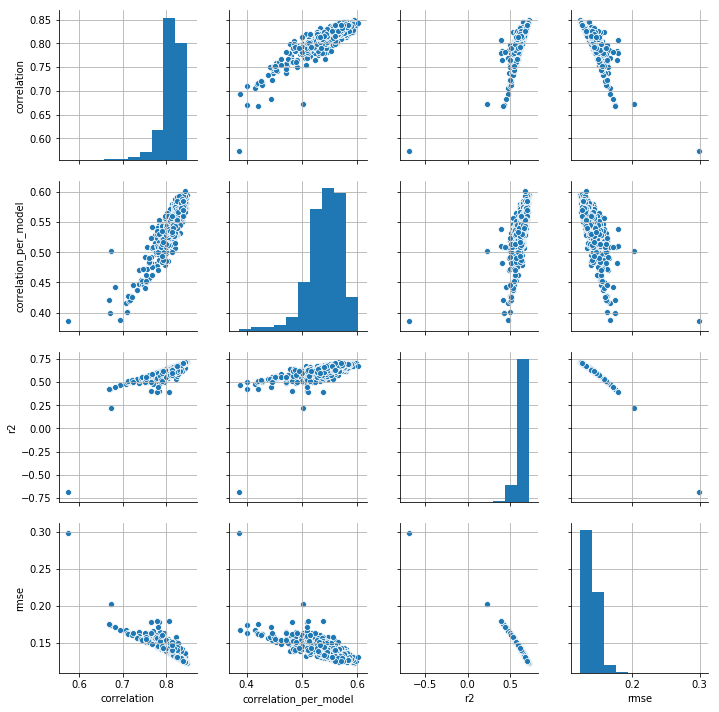

In [11]:
pg = sns.pairplot(df['metric', 'local_lddt'].droplevel(-1, axis='columns'))
for ax in pg.axes.ravel():
    ax.grid()

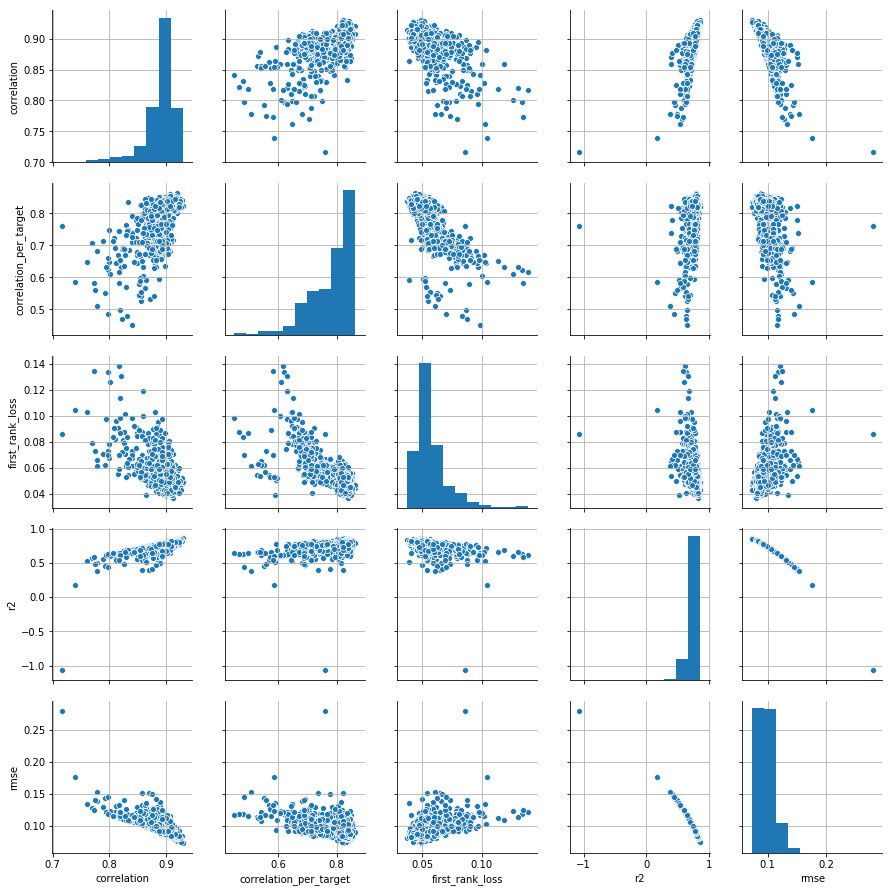

In [12]:
pg = sns.pairplot(df['metric', 'global_lddt'].droplevel(-1, axis='columns'))
for ax in pg.axes.ravel():
    ax.grid()

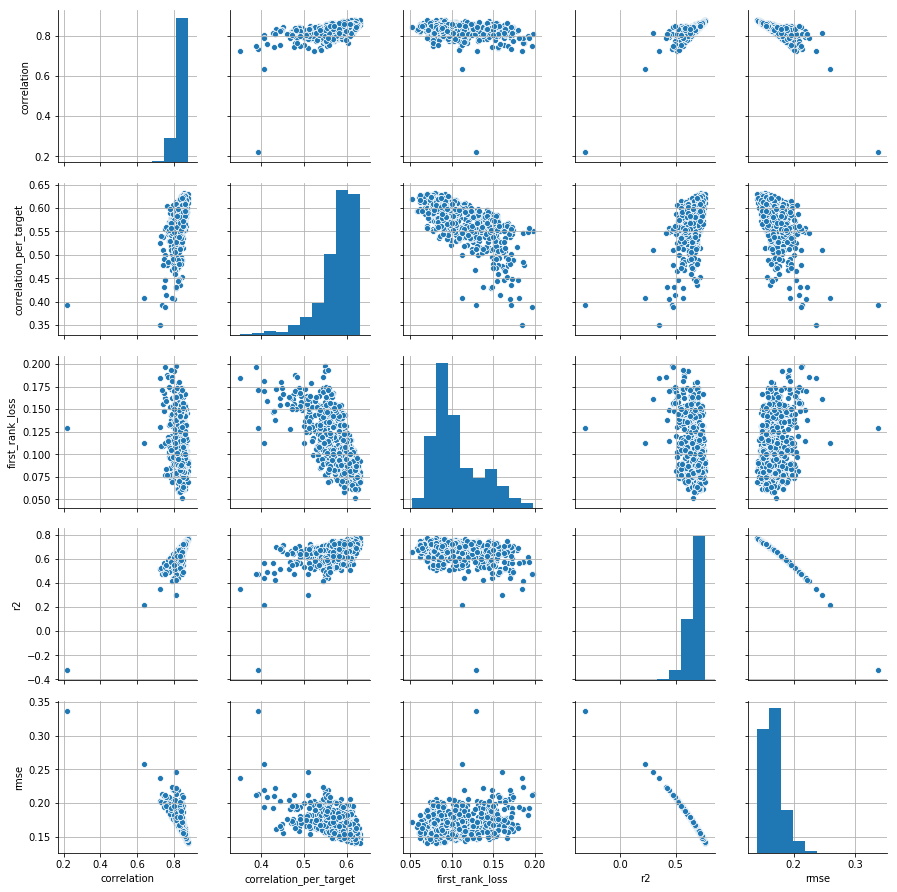

In [13]:
pg = sns.pairplot(df['metric', 'global_gdtts'].droplevel(-1, axis='columns'))
for ax in pg.axes.ravel():
    ax.grid()

## Global vs local

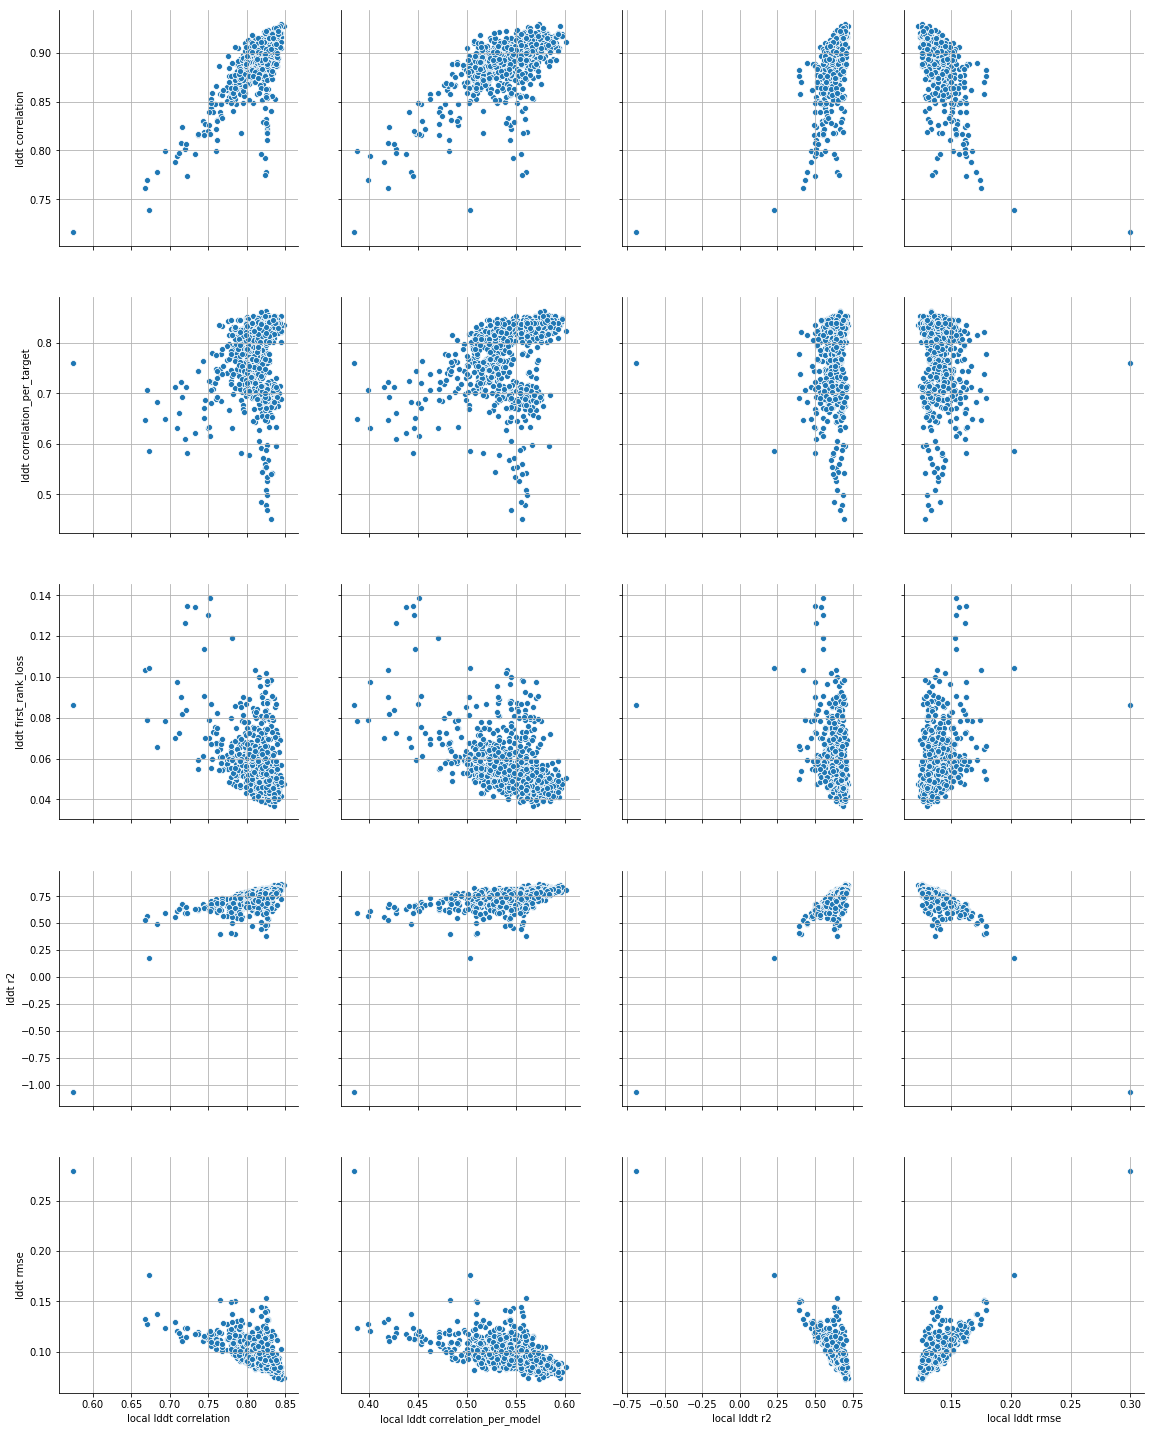

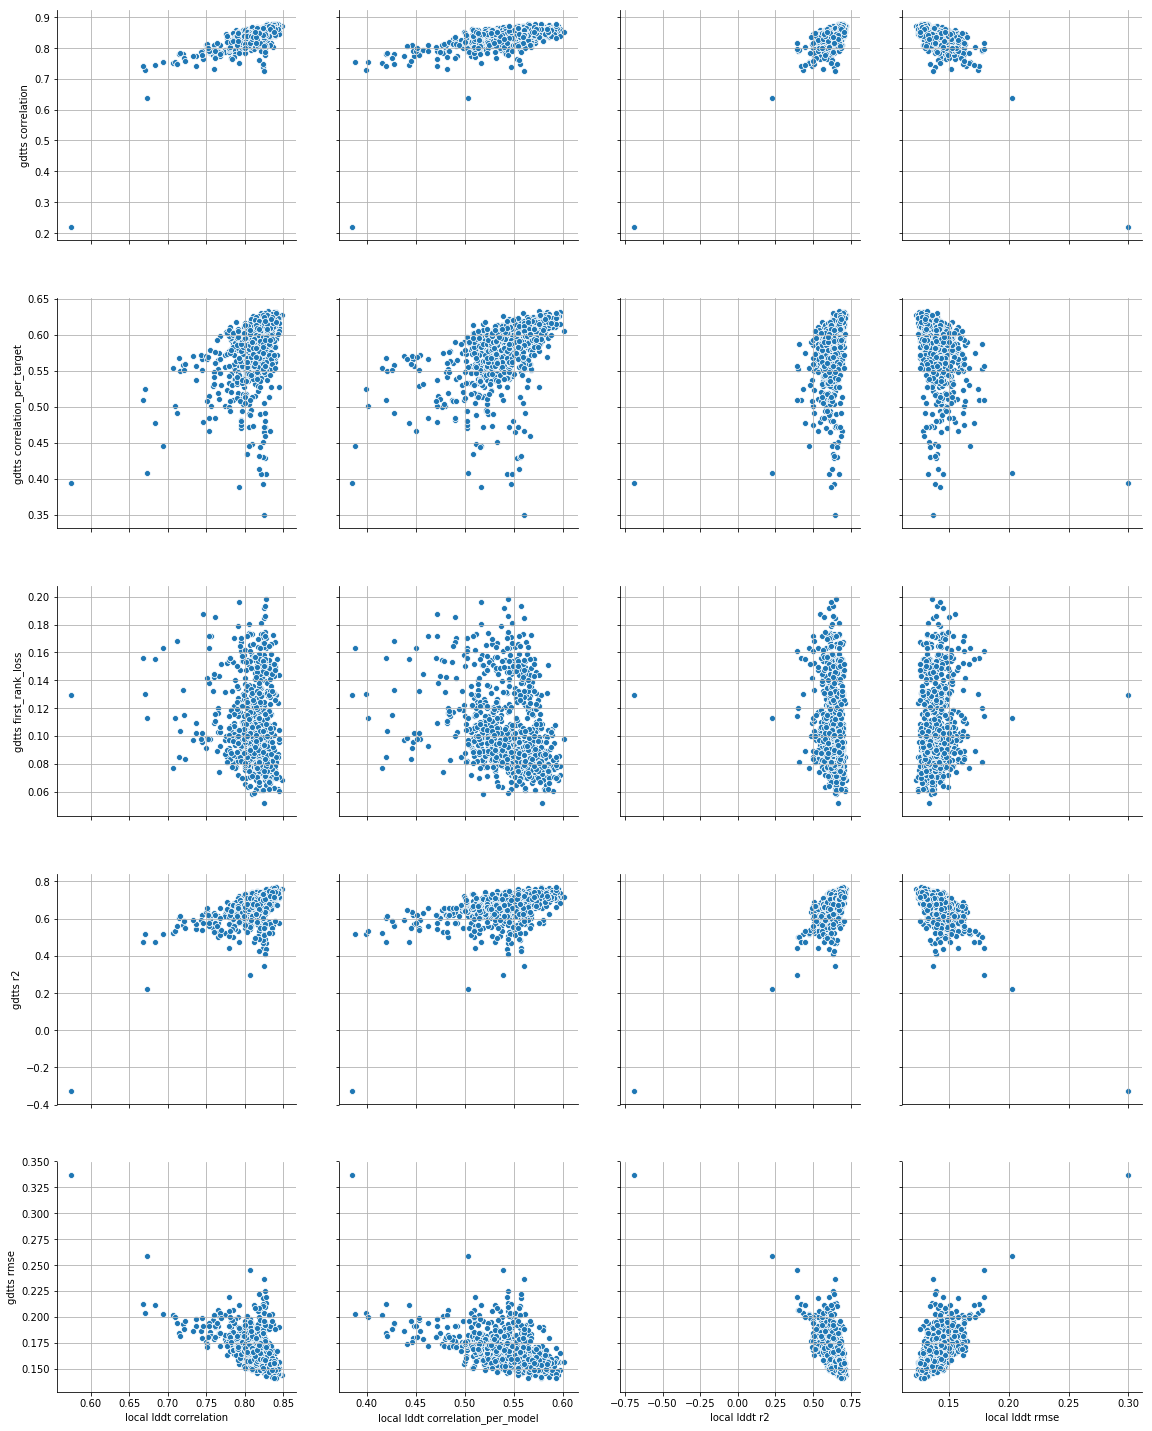

In [14]:
for g in ('global_lddt', 'global_gdtts'):
    pg = sns.pairplot(
        df, 
        height=4,
        y_vars=list(c for c in df.columns if c[0] == 'metric' and c[1] == g),
        x_vars=list(c for c in df.columns if c[0] == 'metric' and c[1] == 'local_lddt')
    )
    
    for ax in pg.axes.ravel():
        ax.grid()
        if len(ax.get_xlabel()) > 0:
            ax.set_xlabel('local lddt ' + ax.get_xlabel().split("'")[5])
        if len(ax.get_ylabel()) > 0:
            split = ax.get_ylabel().split("'")
            ax.set_ylabel(f'{split[3][7:]} {split[5]}')

## Parameters

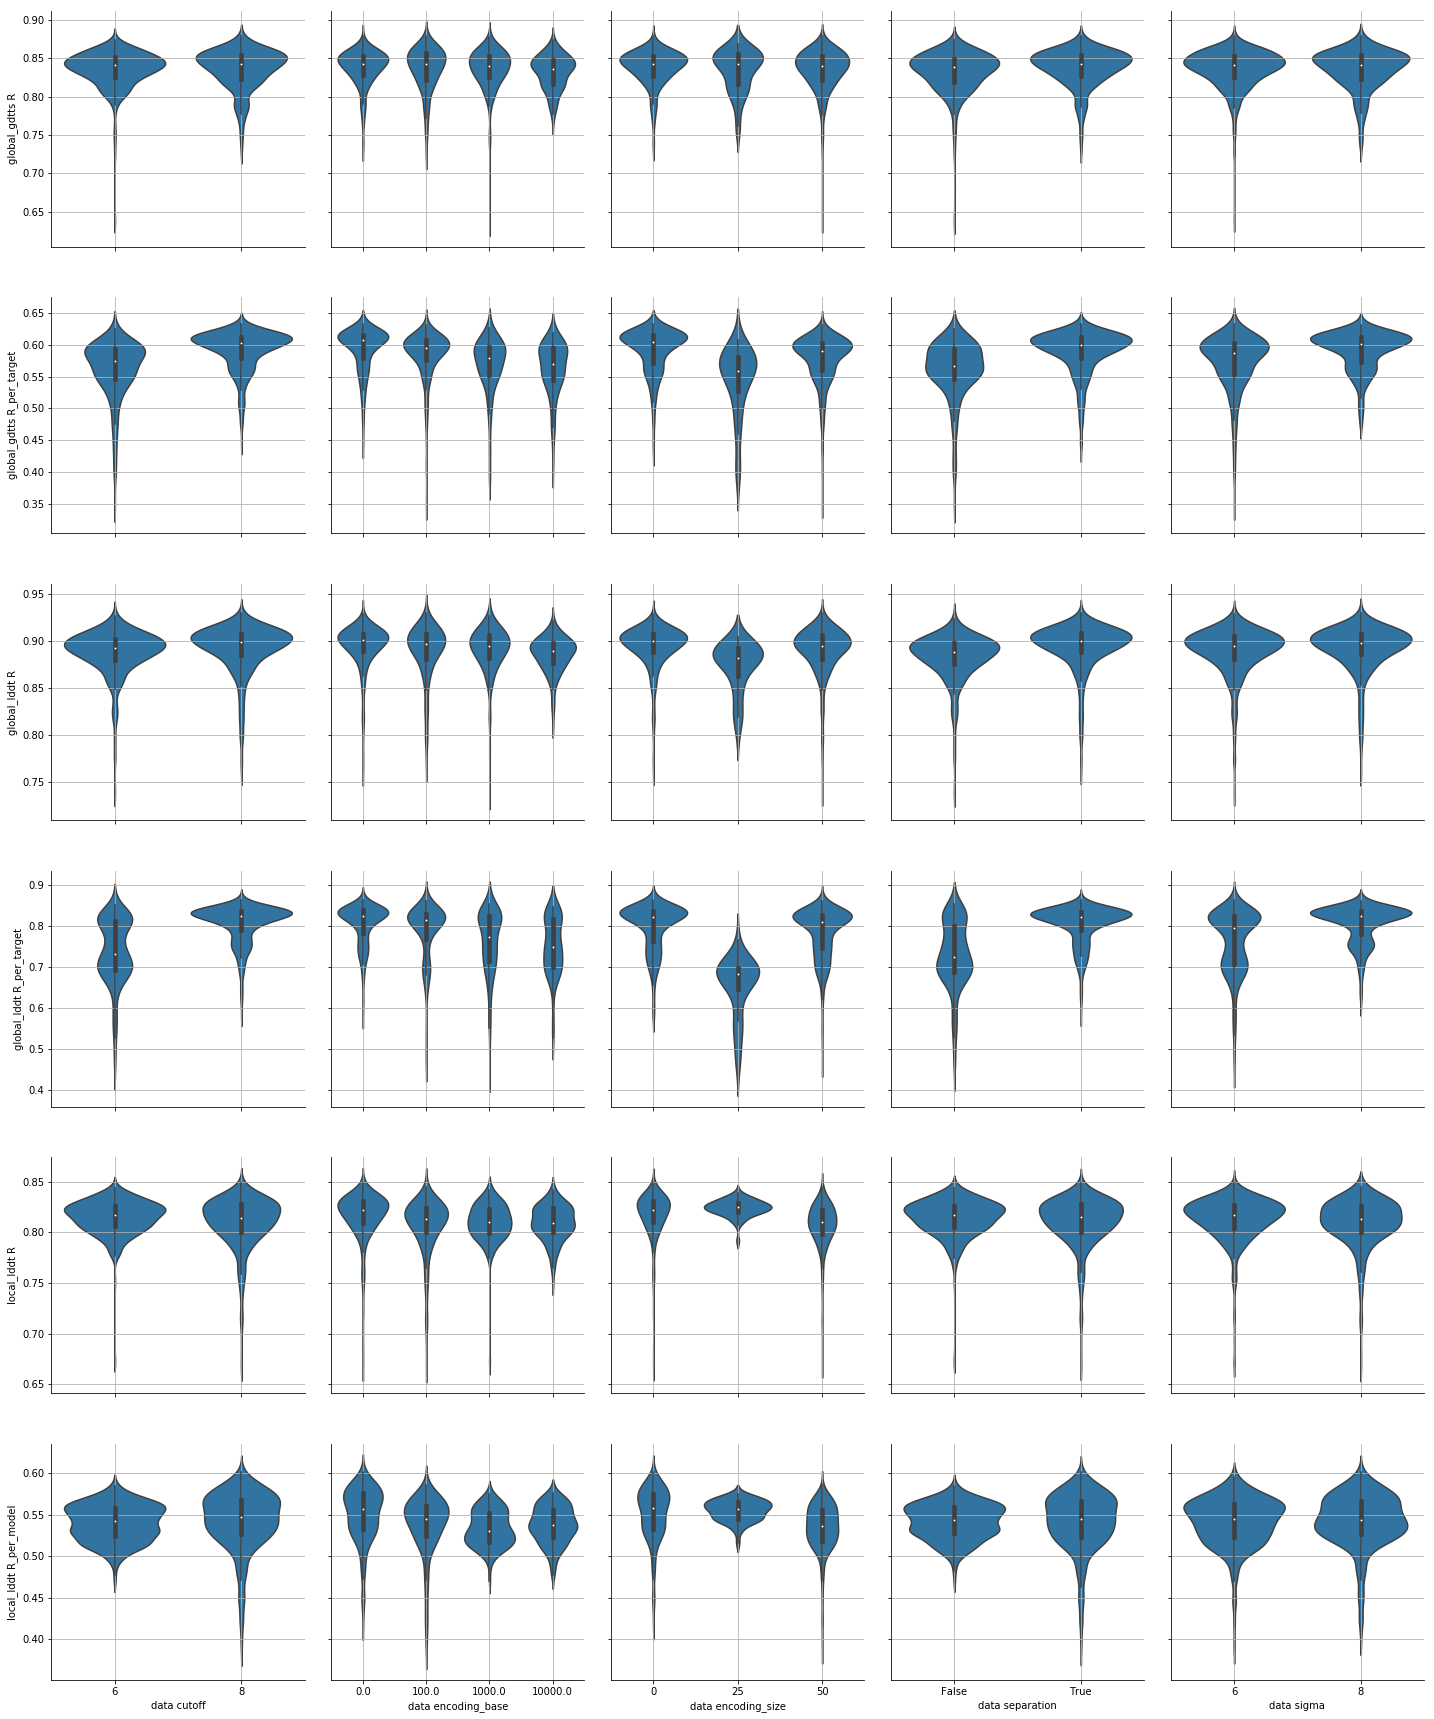

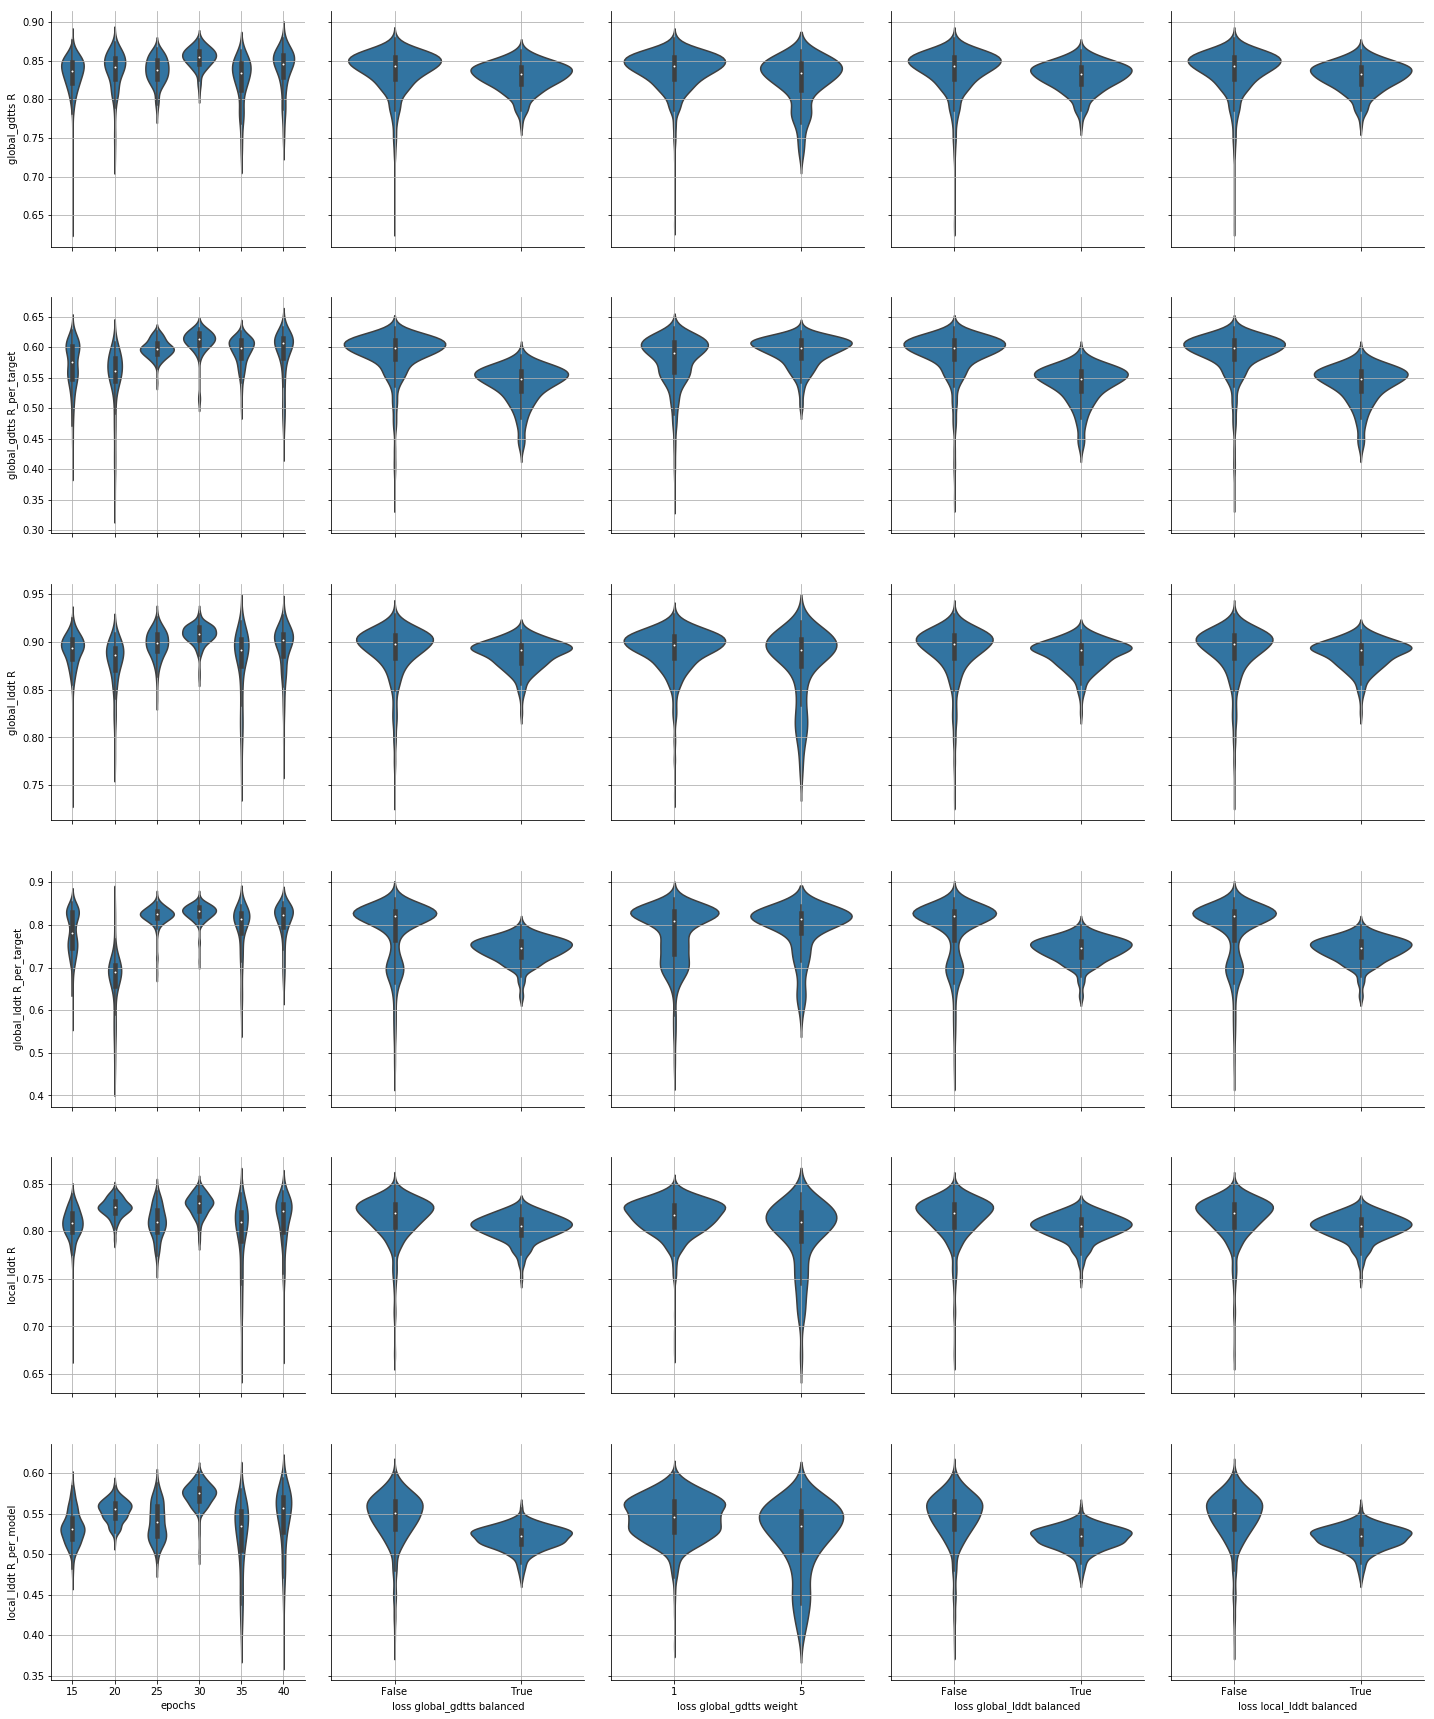

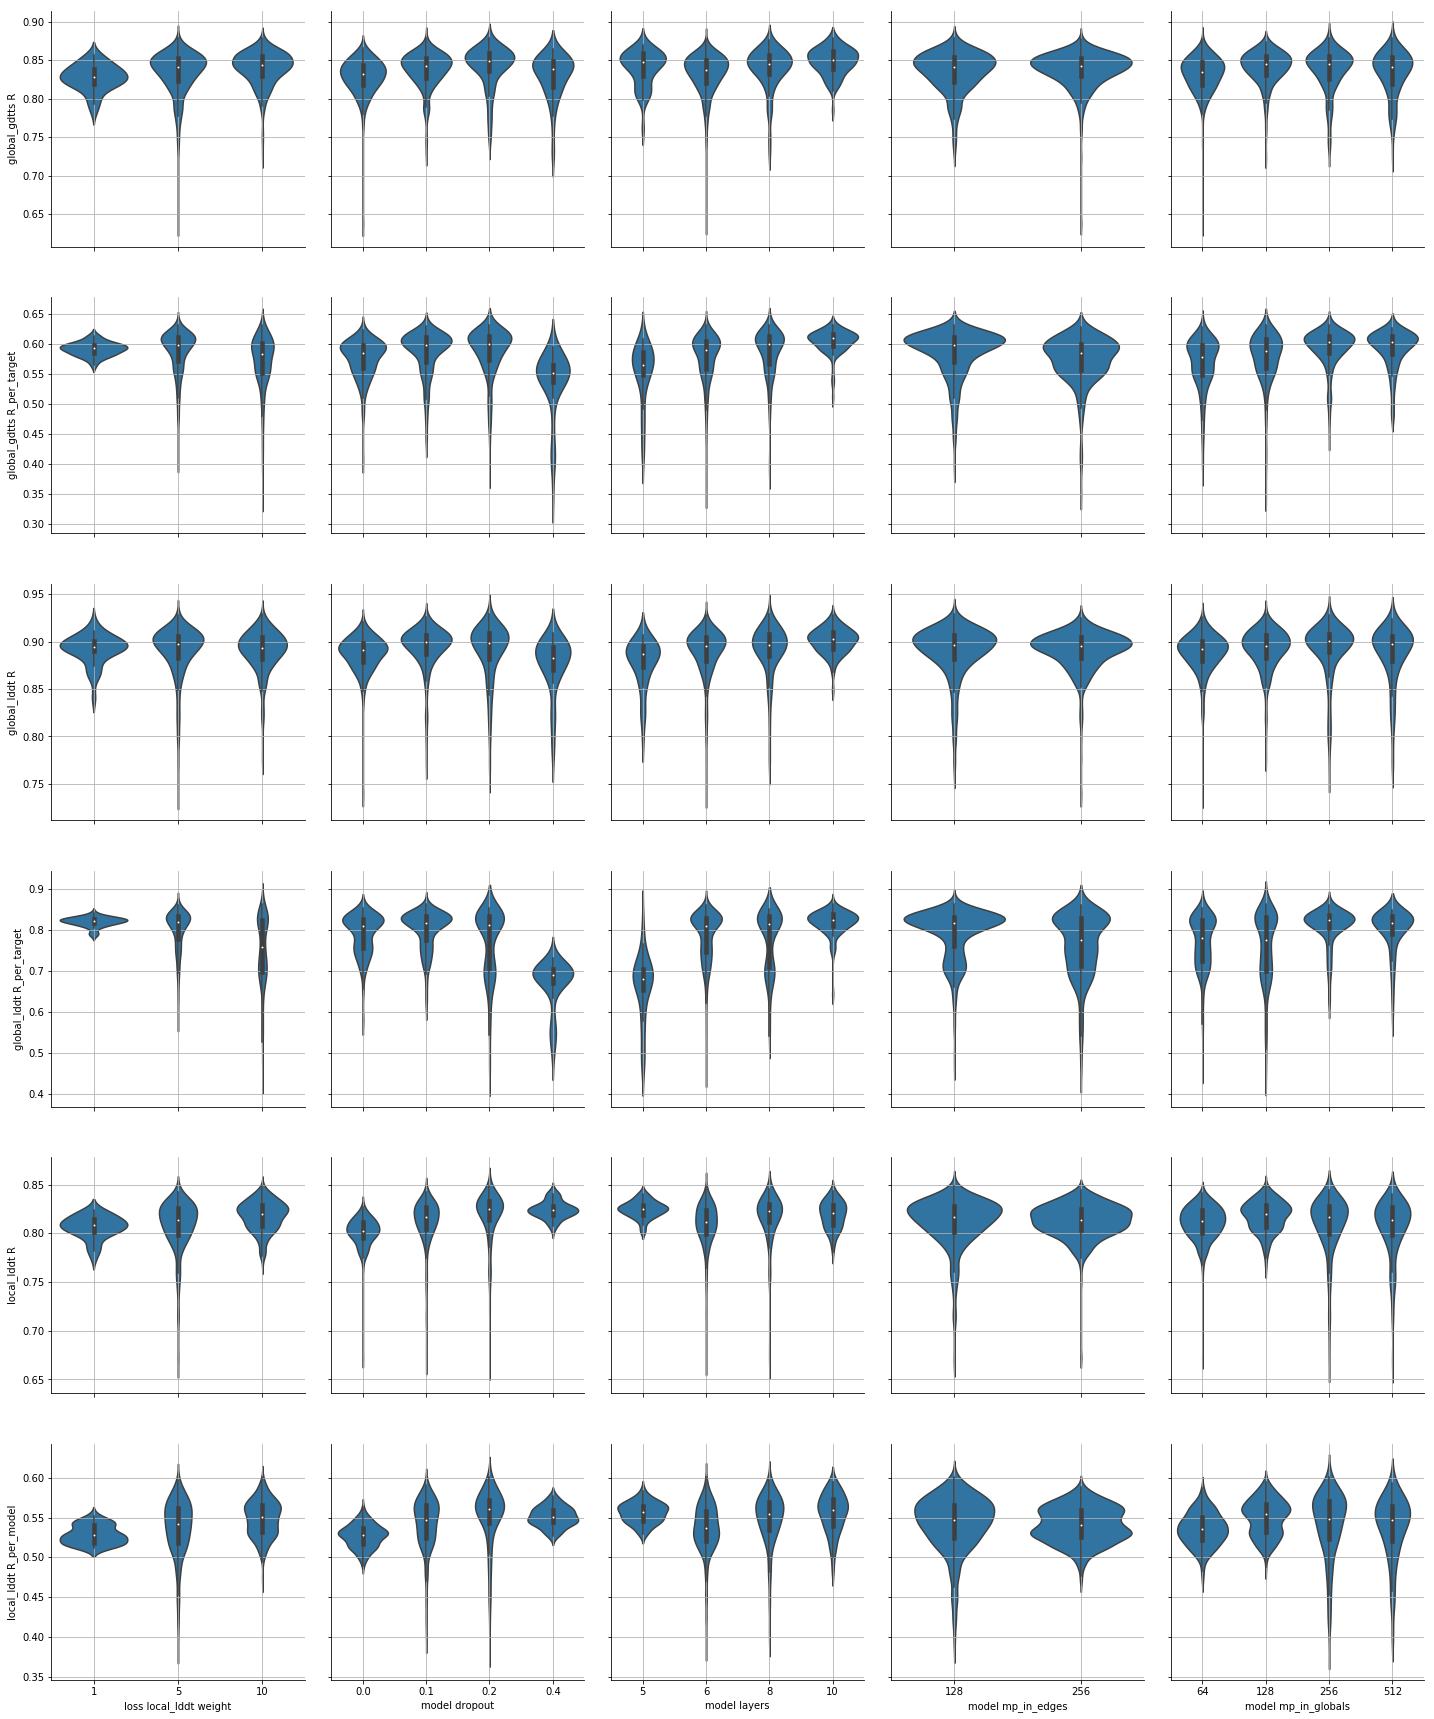

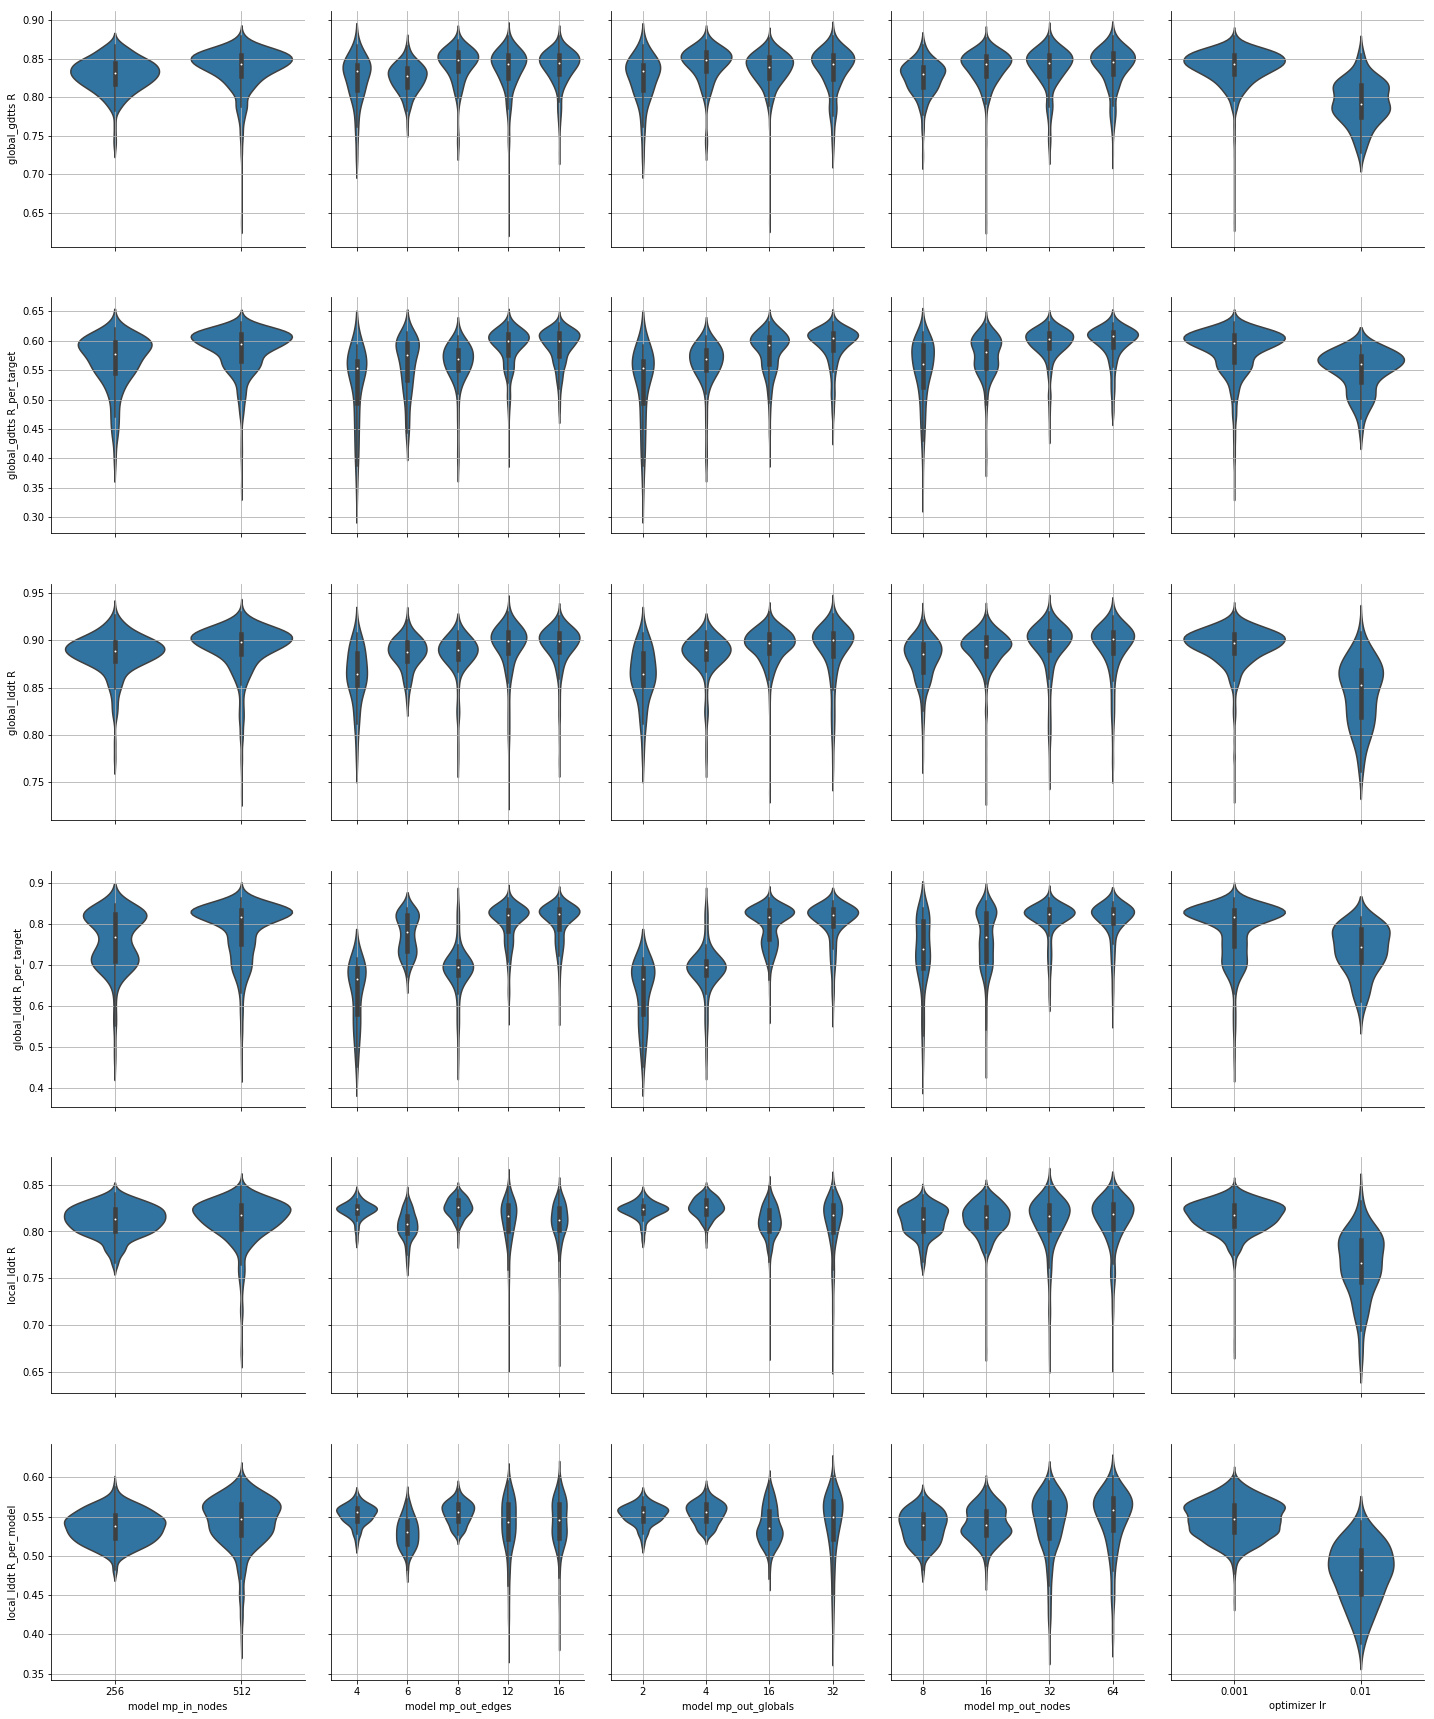

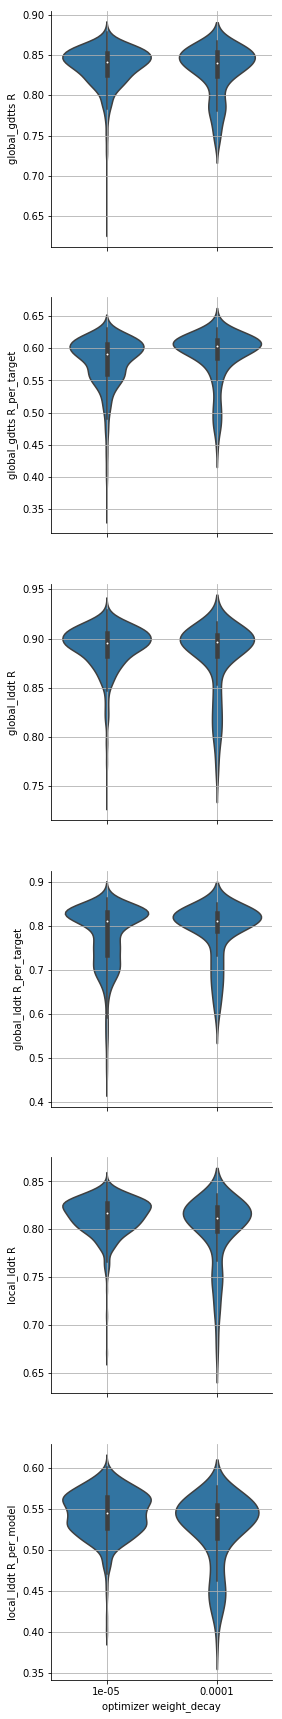

In [15]:
metrics = list(c for c in df.columns if c[0] == 'metric' and c[2].startswith('correlation'))
hps = list(c for c in df.columns if c[0] == 'hp')

for i in range(0, len(hps), 5):
    pg = sns.PairGrid(
        df[(df['metric'] > 0).all(axis=1)],
        height=4,
        y_vars=metrics,
        x_vars=hps[i: i+5],
    )
    pg.map(sns.violinplot)
    for ax in pg.axes.ravel():
        ax.grid()
    for ax, name in zip(pg.axes[-1, :], (' '.join(hp[1:]).strip() for hp in hps[i: i+5])):
        ax.set_xlabel(name)
    for ax, name in zip(pg.axes[:, 0], (m[1] + ' ' + m[2].replace('correlation', 'R') for m in metrics)):
        ax.set_ylabel(name)

### Layers vs cutoff (group by and take best)
- trade off between local and global

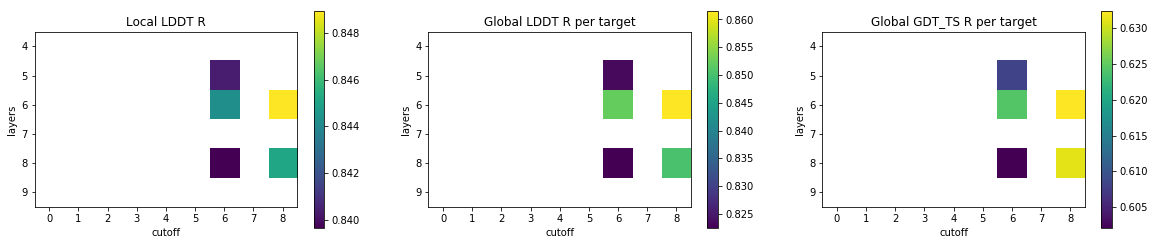

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_cutoff_layers = df.groupby(by=[ix['hp', 'data', 'cutoff'], ix['hp', 'model', 'layers']]) \
    .apply(lambda df: df.metric.max()) \
    .reindex(pd.MultiIndex.from_product([range(0,9), range(4, 10)], names=['cutoff', 'layers'])) \
    .unstack('cutoff')

metrics = {
    'Local LDDT R': df_cutoff_layers['local_lddt', 'correlation'], 
    'Global LDDT R per target': df_cutoff_layers['global_lddt', 'correlation_per_target'], 
    'Global GDT_TS R per target': df_cutoff_layers['global_gdtts', 'correlation_per_target'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('cutoff')
    ax.set_xticks(range(len(df_img.columns.get_level_values('cutoff'))))
    ax.set_xticklabels(df_img.columns.get_level_values('cutoff'))
    ax.set_ylabel('layers')
    ax.set_yticks(range(len(df_img.index.get_level_values('layers'))))
    ax.set_yticklabels(df_img.index.get_level_values('layers'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

### Layers vs dropout (group by and take best)
- Keeping dropout low helps, so maybe increase network size?

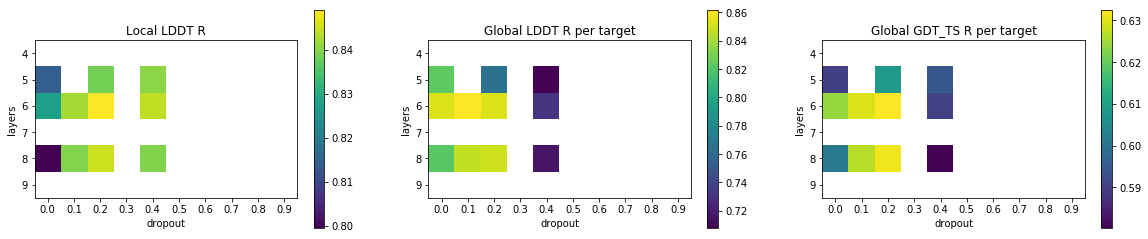

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_dropout_layers = df.groupby(by=[ix['hp', 'model', 'dropout'], ix['hp', 'model', 'layers']]) \
    .apply(lambda df: df.metric.max()) \
    .reindex(pd.MultiIndex.from_product([np.linspace(0, 1, 10, endpoint=False).round(1), range(4, 10)], names=['dropout', 'layers'])) \
    .unstack('dropout')

metrics = {
    'Local LDDT R': df_dropout_layers['local_lddt', 'correlation'], 
    'Global LDDT R per target': df_dropout_layers['global_lddt', 'correlation_per_target'], 
    'Global GDT_TS R per target': df_dropout_layers['global_gdtts', 'correlation_per_target'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('dropout')
    ax.set_xticks(range(len(df_img.columns.get_level_values('dropout'))))
    ax.set_xticklabels(df_img.columns.get_level_values('dropout'))
    ax.set_ylabel('layers')
    ax.set_yticks(range(len(df_img.index.get_level_values('layers'))))
    ax.set_yticklabels(df_img.index.get_level_values('layers'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

### Node Encoding (group by and take best)

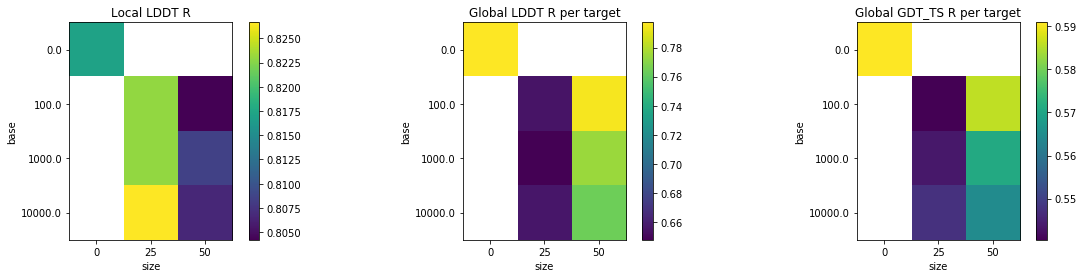

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_encsize_encbase = df.fillna({('hp', 'data', 'encoding_base', ''): 0}) \
    .groupby(by=[ix['hp', 'data', 'encoding_size'], ix['hp', 'data', 'encoding_base']]) \
    .apply(lambda df: df.metric.mean())
df_encsize_encbase.index.names = ['enc size', 'enc base']
df_encsize_encbase = df_encsize_encbase.unstack('enc size')

metrics = {
    'Local LDDT R': df_encsize_encbase['local_lddt', 'correlation'], 
    'Global LDDT R per target': df_encsize_encbase['global_lddt', 'correlation_per_target'], 
    'Global GDT_TS R per target': df_encsize_encbase['global_gdtts', 'correlation_per_target'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('size')
    ax.set_xticks(range(len(df_img.columns.get_level_values('enc size'))))
    ax.set_xticklabels(df_img.columns.get_level_values('enc size'))
    ax.set_ylabel('base')
    ax.set_yticks(range(len(df_img.index.get_level_values('enc base'))))
    ax.set_yticklabels(df_img.index.get_level_values('enc base'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

## Separation vs cutoff (group by and take best)

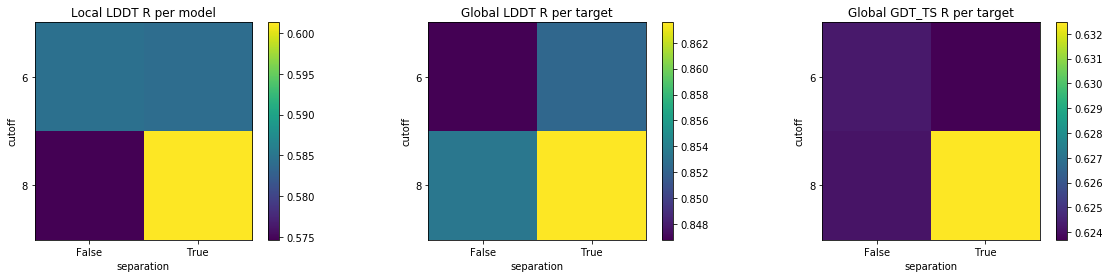

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_encsize_encbase = df \
    .groupby(by=[ix['hp', 'data', 'separation'], ix['hp', 'data', 'cutoff']]) \
    .apply(lambda df: df.metric.max())
df_encsize_encbase.index.names = ['separation', 'cutoff']
df_encsize_encbase = df_encsize_encbase.unstack('separation')

metrics = {
    'Local LDDT R per model': df_encsize_encbase['local_lddt', 'correlation_per_model'], 
    'Global LDDT R per target': df_encsize_encbase['global_lddt', 'correlation_per_target'], 
    'Global GDT_TS R per target': df_encsize_encbase['global_gdtts', 'correlation_per_target'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('separation')
    ax.set_xticks(range(len(df_img.columns.get_level_values('separation'))))
    ax.set_xticklabels(df_img.columns.get_level_values('separation'))
    ax.set_ylabel('cutoff')
    ax.set_yticks(range(len(df_img.index.get_level_values('cutoff'))))
    ax.set_yticklabels(df_img.index.get_level_values('cutoff'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))

## Sigma vs cutoff (group by and take best)

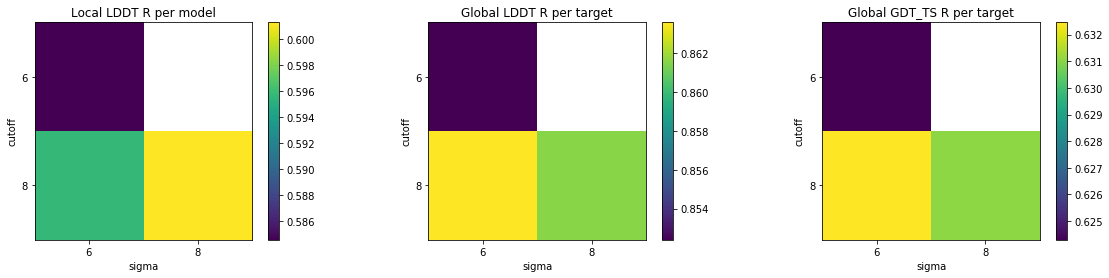

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))

df_encsize_encbase = df \
    .groupby(by=[ix['hp', 'data', 'sigma'], ix['hp', 'data', 'cutoff']]) \
    .apply(lambda df: df.metric.max())
df_encsize_encbase.index.names = ['sigma', 'cutoff']
df_encsize_encbase = df_encsize_encbase.unstack('sigma')

metrics = {
    'Local LDDT R per model': df_encsize_encbase['local_lddt', 'correlation_per_model'], 
    'Global LDDT R per target': df_encsize_encbase['global_lddt', 'correlation_per_target'], 
    'Global GDT_TS R per target': df_encsize_encbase['global_gdtts', 'correlation_per_target'], 
}

for ax, (title, df_img) in zip(axes, metrics.items()):
    im=ax.imshow(df_img.values)
    ax.set_title(title)
    ax.set_xlabel('sigma')
    ax.set_xticks(range(len(df_img.columns.get_level_values('sigma'))))
    ax.set_xticklabels(df_img.columns.get_level_values('sigma'))
    ax.set_ylabel('cutoff')
    ax.set_yticks(range(len(df_img.index.get_level_values('cutoff'))))
    ax.set_yticklabels(df_img.index.get_level_values('cutoff'))
    plt.colorbar(im, ax=ax)
    display(df_img.style.set_caption(title).applymap(lambda v: 'opacity:.2' if np.isnan(v) else ''))